# Survival Model #

@roman_avj

7 nov 2023

In [132]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import boto3
import sqlalchemy

from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

from xgbse import XGBSEStackedWeibull
from xgbse.extrapolation import extrapolate_constant_risk
import lifelines

from scipy.integrate import simpson
from scipy.optimize import brentq

import geopandas as gpd
import folium

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from xgbse.metrics import (
    approx_brier_score,
    dist_calibration_score,
    concordance_index
)


# Setup

## Data

In [133]:
# read
df_model = pd.read_parquet('../../data/data2analyze_clean_v2_sale.parquet')
df_model.info()

# add if has maintenance
df_model['has_maintenance'] = df_model['cost_of_maintenance'].apply(lambda x: 1 if x > 0 else 0)

# clip columns with 'lag' up to 99 percentile
vars_lag = df_model.columns[df_model.columns.str.contains('lag')]
df_model[vars_lag] = df_model[vars_lag].clip(upper=df_model[vars_lag].quantile(0.99), axis=1)

# look rows with maximum time2event
df_max = df_model[df_model['time2event'] == df_model['time2event'].max()]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47397 entries, 0 to 47396
Columns: 141 entries, id to cosine_tmonth
dtypes: datetime64[us](2), float64(122), int32(1), int64(4), object(9), string(3)
memory usage: 50.8+ MB


## Wrangle

In [3]:
# get maxmimum time2event
# get a random id from df_max, first trye for event == 1, then for event == 0
id_max = df_max[df_max['event'] == 1]['id'].sample(1, random_state=8).values[0]
if pd.isna(id_max):
    id_max = df_max[df_max['event'] == 0]['id'].sample(1, random_state=8).values[0]

# for id_max add 1 to time2event and set event = 1
df_model.loc[df_model['id'] == id_max, 'time2event'] =\
     df_model.loc[df_model['id'] == id_max, 'time2event'] + 1

df_model.loc[df_model['id'] == id_max, 'event'] = 1

## Transform

In [4]:
# select columns
vars_x_categorical = ['property_type']
vars_x_discrete = []
vars_x_woe = ['woe_marketplace', 'woe_seller', 'woe_id_sepomex']
vars_x_numerical = [
    'first_price', 'diff_first_prediction', 
    # 'prediction_price_per_square_meter',
    # 'surface_total',
    'page_on_marketplace'
    ]
vars_x_binary = []
vars_x_geographic = ['latitude', 'longitude']
vars_x_time = ['sine_tmonth', 'cosine_tmonth']

vars_x_names = vars_x_categorical + vars_x_numerical + vars_x_binary + vars_x_discrete + vars_x_geographic + vars_x_woe + vars_x_time

# corroborate there are not duplicates in the vars_x_names
print(len(vars_x_names))
print(len(set(vars_x_names)))

11
11


In [135]:
print(vars_x_names)

['property_type', 'first_price', 'diff_first_prediction', 'page_on_marketplace', 'latitude', 'longitude', 'woe_marketplace', 'woe_seller', 'woe_id_sepomex', 'sine_tmonth', 'cosine_tmonth']


In [5]:
# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .assign(prediction_price=lambda x: x['first_price'].div(1e+6))
    .astype({col: 'category' for col in vars_x_categorical})
    .astype({col: np.float64 for col in vars_x_numerical + vars_x_discrete + vars_x_binary + vars_x_geographic})
    .astype({col: np.int8 for col in vars_x_binary})
    [vars_x_names]
)
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47397 entries, 0 to 47396
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   property_type          47397 non-null  category
 1   first_price            47397 non-null  float64 
 2   diff_first_prediction  47397 non-null  float64 
 3   page_on_marketplace    47397 non-null  float64 
 4   latitude               47397 non-null  float64 
 5   longitude              47397 non-null  float64 
 6   woe_marketplace        47397 non-null  float64 
 7   woe_seller             47397 non-null  float64 
 8   woe_id_sepomex         47397 non-null  float64 
 9   sine_tmonth            47397 non-null  float64 
 10  cosine_tmonth          47397 non-null  float64 
dtypes: category(1), float64(10)
memory usage: 3.7 MB


In [6]:
# one hot encoding #
data_x_numeric = OneHotEncoder().fit_transform(data_x)
colnames_x_numeric = data_x_numeric.columns

# boxcox (yeo-johnson) transformation BY property type #
def boxcox(X):
    # power_transform
    power_transform = PowerTransformer(method='yeo-johnson', standardize=True).fit(X)
    X_transf = power_transform.transform(X)
    return X_transf, power_transform

# get boxcox transformation for each property type
boxcox_vars_property = [
    # 'first_price', 'prediction_price_per_square_meter', 'surface_total',
    'first_price',
]
# difference between vars_x_numerical and boxcox_vars_property
boxcox_vars_all = list(set(vars_x_numerical) - set(boxcox_vars_property))
# box cox transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get boxcox transformation
data_x_numeric.loc[idx_house, boxcox_vars_property], pt_house = boxcox(data_x_numeric.loc[idx_house, boxcox_vars_property])
data_x_numeric.loc[idx_apartment, boxcox_vars_property], pt_apartment = boxcox(data_x_numeric.loc[idx_apartment, boxcox_vars_property])
data_x_numeric[boxcox_vars_all], pt_all = boxcox(data_x_numeric[boxcox_vars_all])

# scale #
# scale
def scale(X):
    # power_transform
    standard_scaler = StandardScaler().fit(X)
    X_transf = standard_scaler.transform(X)
    return X_transf, standard_scaler

# get scaler transformation for each property type
standard_vars = vars_x_discrete
# scaler transformation by property type #
# subset data
# idx_house = (data_x_numeric['property_type=house'] >= 1)
# idx_apartment = (data_x_numeric['property_type=house'] < 1)

# # get scaler transformation
# data_x_numeric.loc[idx_house, standard_vars], st_house = scale(data_x_numeric.loc[idx_house, standard_vars])
# data_x_numeric.loc[idx_apartment, standard_vars], st_apartment = scale(data_x_numeric.loc[idx_apartment, standard_vars])
# to numeric
data_x_numeric = data_x_numeric.to_numpy()



In [139]:
pt_all.feature_names_in_

array(['page_on_marketplace', 'diff_first_prediction'], dtype=object)

In [136]:

boxcox_vars_all


['page_on_marketplace', 'diff_first_prediction']

In [8]:
colnames_x_numeric

Index(['property_type=house', 'first_price', 'diff_first_prediction',
       'page_on_marketplace', 'latitude', 'longitude', 'woe_marketplace',
       'woe_seller', 'woe_id_sepomex', 'sine_tmonth', 'cosine_tmonth'],
      dtype='object')

In [9]:
# to numeric
pd.DataFrame(data_x_numeric, columns=colnames_x_numeric).head(3)

,property_type=house,first_price,diff_first_prediction,page_on_marketplace,latitude,longitude,woe_marketplace,woe_seller,woe_id_sepomex,sine_tmonth,cosine_tmonth
0,0.0,-1.618895,1.396642,0.019935,19.477268,-99.206326,0.533409,7.489059,0.967119,1.224647e-16,-1.0
1,0.0,-1.055594,0.099963,1.047877,19.474745,-99.204443,-1.017859,-0.025435,0.967119,8.660254e-01,-0.5
2,0.0,-1.543643,-0.054126,0.206054,19.471410,-99.207310,0.223425,-0.025435,0.967119,8.660254e-01,-0.5


In [10]:
# give the id's of the rows
data_x_numeric = np.hstack((data_x_numeric, df_model['id'].to_numpy().reshape(-1,1)))

# get the row with id_max
data_x_max = data_x_numeric[df_model['id'] == id_max]
idx_delete = df_model[df_model['id'] == id_max].index

# delete row_id_max from data_x_numeric
data_x_numeric = np.delete(data_x_numeric, idx_delete, axis=0)

# also delete from data_y
data_y_max = data_y[idx_delete]
data_y = np.delete(data_y, idx_delete, axis=0)

## Train & Test

In [11]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.1, random_state=42
)

In [12]:
# get the id's of the train and test
train_ids = X_train[:, -1]
test_ids = X_test[:, -1]

# add id_max to X_train & y_train
X_train = np.vstack([X_train, data_x_max])
y_train = np.hstack([y_train, data_y_max])

# delete the id's from the data
X_train = np.delete(X_train, -1, axis=1)
X_test = np.delete(X_test, -1, axis=1)

In [13]:
# get valiadtion data
X_train_bis, X_val, y_train_bis, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Get Best Model

In [14]:
# create vanilla model
class sklearn_wei(XGBSEStackedWeibull):
  
    def get_params2(self):
        return(self.get_params()['xgb_params'])
      
    def set_params(self,**params):
      old_params = self.get_params2()
      old_params.update(params)
      self.xgb_params = old_params
      return(self)

ok = sklearn_wei()

In [15]:
# cross validation
opt = BayesSearchCV(
  estimator = ok,
  scoring = make_scorer(concordance_index),
  n_iter = 5,
  random_state = 42,
  cv = StratifiedKFold(n_splits = 4, shuffle = True),
  n_jobs = -1,
  n_points = 1,
  verbose = 1,
  search_spaces = {
    'max_depth': Integer(low = 2, high = 32, prior = 'log-uniform'),
    'learning_rate': Real(0.01, 1, "uniform"),
    'reg_alpha': Real(low=0, high = 1,prior = "uniform"),
    'reg_lambda': Real(low=0, high = 1,prior = "uniform"),
  },
  fit_params = {}
 )

opt.fit(
  X_train_bis,
  y_train_bis,
  time_bins = range(1, 171, 1),
  validation_data= (X_val, y_val),
  early_stopping_rounds=10,
  verbose_eval=50
)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[0]	validation-aft-nloglik:7.44570
[0]	validation-aft-nloglik:7.44723
[0]	validation-aft-nloglik:7.44449
[0]	validation-aft-nloglik:7.43206
[19]	validation-aft-nloglik:3.30317
[19]	validation-aft-nloglik:3.29609
[19]	validation-aft-nloglik:3.30136
[18]	validation-aft-nloglik:3.30089
Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[0]	validation-aft-nloglik:3.76538
[0]	validation-aft-nloglik:3.78326
[12]	validation-aft-nloglik:3.36469
[12]	validation-aft-nloglik:3.36384
[0]	validation-aft-nloglik:3.76513
[0]	validation-aft-nloglik:3.76424
[12]	validation-aft-nloglik:3.35893
[12]	validation-aft-nloglik:3.36432
Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[0]	validation-aft-nloglik:6.99118
[0]	validation-aft-nloglik:6.99016
[0]	validation-aft-nloglik:6.98983
[16]	validation-aft-nloglik:3.30950
[17]	validation-aft-nloglik:3.30732
[17]	validation-aft-nloglik:3.31203
[0]	validation-aft-nloglik:7.00193
[19]	validation-aft-nloglik:3.30993
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[0]	validation-aft-nloglik:3.89028


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[0]	validation-aft-nloglik:3.89484
[0]	validation-aft-nloglik:3.89860
[0]	validation-aft-nloglik:3.89860
[16]	validation-aft-nloglik:3.29616
[28]	validation-aft-nloglik:3.29178
[30]	validation-aft-nloglik:3.29177
[36]	validation-aft-nloglik:3.29184
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[0]	validation-aft-nloglik:3.93300


/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[0]	validation-aft-nloglik:3.94179
[0]	validation-aft-nloglik:3.93702
[0]	validation-aft-nloglik:3.93364
[12]	validation-aft-nloglik:3.30925
[13]	validation-aft-nloglik:3.30945
[14]	validation-aft-nloglik:3.31189
[13]	validation-aft-nloglik:3.30672
[0]	validation-aft-nloglik:7.44973
[19]	validation-aft-nloglik:3.29982


BayesSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=True),
              estimator=sklearn_wei(weibull_params={},
                                    xgb_params={'aft_loss_distribution': 'normal',
                                                'aft_loss_distribution_scale': 1,
                                                'booster': 'dart',
                                                'colsample_bynode': 0.5,
                                                'eval_metric': 'aft-nloglik',
                                                'learning_rate': 0.05,
                                                'max_depth': 8,
                                                'min_child_weight': 50,
                                                'objective': 'survival:aft',
                                                'subs...
              scoring=make_scorer(concordance_index),
              search_spaces={'learning_rate': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=32, prior='log-uniform', transform='normalize'),
                             'reg_alpha': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=1, prior='uniform', transform='normalize')},
              verbose=1)

In [16]:
df_results = (
  pd.DataFrame(opt.cv_results_).sort_values(by = 'rank_test_score', ascending = True)
  .assign(
    max_depth=lambda x: x['params'].apply(lambda y: y['max_depth']),
    learning_rate=lambda x: x['params'].apply(lambda y: y['learning_rate']),
    reg_alpha=lambda x: x['params'].apply(lambda y: y['reg_alpha']),
    reg_lambda=lambda x: x['params'].apply(lambda y: y['reg_lambda'])
    )
    [[
      'max_depth', 'learning_rate', 'reg_alpha', 'reg_lambda',
      'mean_test_score', 'std_test_score', 'mean_fit_time']]
  )

df_results

,max_depth,learning_rate,reg_alpha,reg_lambda,mean_test_score,std_test_score,mean_fit_time
0,15,0.416003,0.932868,0.315800,0.695292,0.003655,1.020019
4,7,0.801558,0.526620,0.715713,0.692876,0.006723,0.562517
2,26,0.450384,0.104859,0.433333,0.689715,0.004501,0.993470
3,3,0.814272,0.598047,0.802765,0.688689,0.005446,0.758328
1,23,0.839014,0.303410,0.951224,0.686668,0.002418,0.593434


# Train Best Model

## Fit

In [17]:
# best params
best_xgbse_params = opt.best_estimator_.get_params2()
best_xgbse_params

{'objective': 'survival:aft',
 'eval_metric': 'aft-nloglik',
 'aft_loss_distribution': 'normal',
 'aft_loss_distribution_scale': 1,
 'tree_method': 'hist',
 'learning_rate': 0.4160029192647807,
 'max_depth': 15,
 'booster': 'dart',
 'subsample': 0.5,
 'min_child_weight': 50,
 'colsample_bynode': 0.5,
 'reg_alpha': 0.9328679988478339,
 'reg_lambda': 0.3157995934870487}

In [18]:
print(colnames_x_numeric)

Index(['property_type=house', 'first_price', 'diff_first_prediction',
       'page_on_marketplace', 'latitude', 'longitude', 'woe_marketplace',
       'woe_seller', 'woe_id_sepomex', 'sine_tmonth', 'cosine_tmonth'],
      dtype='object')


In [19]:
# add monotonic constraints
monotone_constraints = len(colnames_x_numeric) * [0]

# add descreasing monotonic constraints for 'first_price'
monotone_constraints[colnames_x_numeric.to_list().index('first_price')] = 1
# add increasing monotonic constraints for 'diff_first_prediction'
monotone_constraints[colnames_x_numeric.to_list().index('diff_first_prediction')] = 1
# add increasing monotonic constraints for 'property_type=house'

monotone_constraints = tuple(monotone_constraints)
monotone_constraints

(0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)

In [20]:
# fit weibull
xgboost_params = {
            "objective": "survival:aft",
            "eval_metric": "aft-nloglik",
            "aft_loss_distribution": "normal",
            "aft_loss_distribution_scale": 1,
            "tree_method": "hist",
            "learning_rate": 5e-2,
            "max_depth": 8,
            "booster": "dart",
            "subsample": 0.5,
            "min_child_weight": 50,
            "colsample_bynode": 0.5,
            'monotone_constraints': monotone_constraints
        }
xgbse_weibull = XGBSEStackedWeibull(xgb_params=xgboost_params)
xgbse_weibull.fit(
    X_train_bis, y_train_bis,
    validation_data=(X_val, y_val),
    early_stopping_rounds=10,
    verbose_eval=50,
    time_bins = range(1, 171, 1)
)

[0]	validation-aft-nloglik:13.81623


[50]	validation-aft-nloglik:3.36517
[100]	validation-aft-nloglik:3.27515
[150]	validation-aft-nloglik:3.27298
[155]	validation-aft-nloglik:3.27289


XGBSEStackedWeibull(weibull_params={},
                    xgb_params={'aft_loss_distribution': 'normal',
                                'aft_loss_distribution_scale': 1,
                                'booster': 'dart', 'colsample_bynode': 0.5,
                                'eval_metric': 'aft-nloglik',
                                'learning_rate': 0.05, 'max_depth': 8,
                                'min_child_weight': 50,
                                'monotone_constraints': (0, 1, 1, 0, 0, 0, 0, 0,
                                                         0, 0, 0),
                                'objective': 'survival:aft', 'subsample': 0.5,
                                'tree_method': 'hist'})

In [21]:
# get feature importance
pd.Series(xgbse_weibull.feature_importances_.values(), index=colnames_x_numeric).sort_values(ascending=False)

latitude                 1658.0
longitude                1652.0
page_on_marketplace      1273.0
sine_tmonth               924.0
woe_marketplace           597.0
woe_seller                596.0
diff_first_prediction     529.0
first_price               507.0
woe_id_sepomex            481.0
cosine_tmonth             478.0
property_type=house       238.0
dtype: float64

## Train

In [22]:
def get_xgbse_mean_time(df):
    """Get mean time to event for a given time interval."""
    # get linespace from names of columns
    delta = df.columns.astype(int).to_numpy()
    # get survival probabilities as the values of the dataframe
    surv_probas = df.values

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])

    return(mean_time)

def get_metrics(df):
    df = df.copy()
    cindex = concordance_index_censored(df['event'], df['observed_time'], df['risk_score'])[0]
    # rmse & mape for all with event as True
    # rmse = np.sqrt(np.mean((df[df['event']]['predicted_time'] - df[df['event']]['observed_time'])**2))
    # mape = np.mean(np.abs((df[df['event']]['predicted_time'] - df[df['event']]['observed_time']) / df[df['event']]['observed_time']))
    # return pd.Series({'rmse': rmse, 'mape': mape, 'cindex': cindex})
    return pd.Series({'cindex': cindex})

def get_prediction_df(X, y, colnames, model):
    # get rmse, mape and cindex by listing & property type
    df_pred = (
        pd.DataFrame(X, columns=colnames)
        .assign(
            observed_time=y['Survival_in_days'],
            event=y['Status'],
            predicted_time=model.predict(X).pipe(get_xgbse_mean_time),
            risk_score=lambda x: - x['predicted_time']
        )
        .rename(columns={
        'property_type=house': 'property_type',
        })
        .assign(
            property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
        )  
    )

    return df_pred


In [23]:
# get prediction df
df_pred = get_prediction_df(X_train, y_train, colnames_x_numeric, xgbse_weibull)

# get metrics
table_metrics = (
    df_pred
    .groupby('property_type')
    .apply(get_metrics)
)

# save
# os.makedirs("../../results/best_models", exist_ok=True)
# table_metrics.to_csv("../../results/best_models/best_survival_model_metrics.csv")
table_metrics

,cindex
property_type,
apartment,0.725618
house,0.718156


## Test

### General Metrics

In [24]:
# get prediction df
df_pred = get_prediction_df(X_test, y_test, colnames_x_numeric, xgbse_weibull)

# get metrics
table_metrics = (
    df_pred
    .assign(all=1)
    .groupby('property_type')
    .apply(get_metrics)
)
table_metrics

,cindex
property_type,
apartment,0.714857
house,0.706831


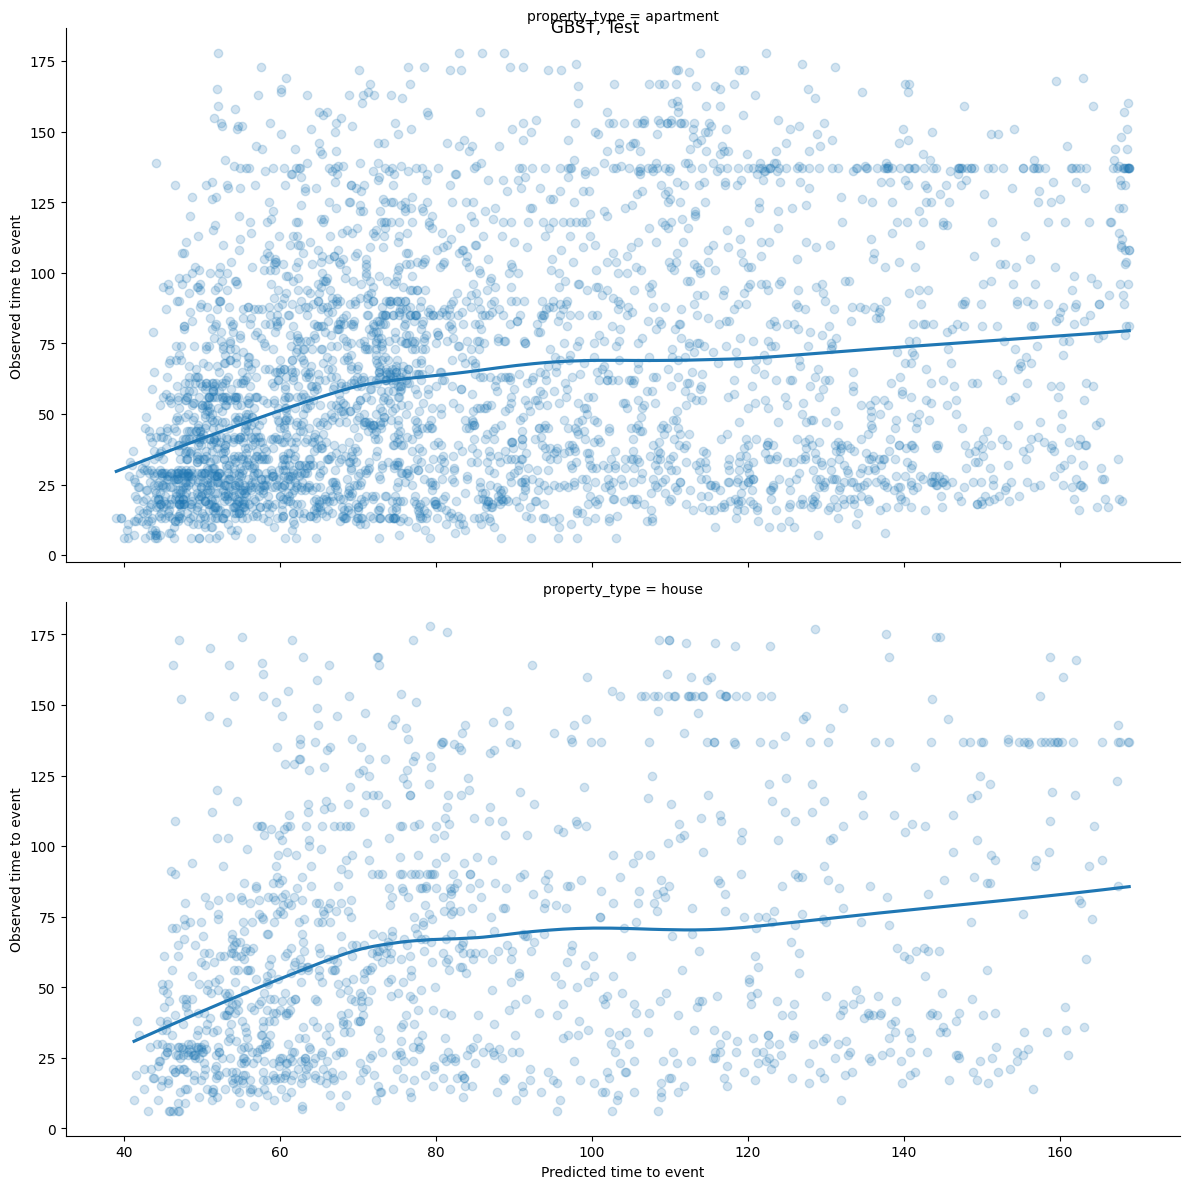

In [25]:
# plot a regplot observed vs predicted, facet grid listing_type and property_type
g = sns.FacetGrid(df_pred, row='property_type')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.regplot, 'predicted_time', 'observed_time', scatter_kws={'alpha':0.2}, ci=False, lowess=True)
g.set_axis_labels('Predicted time to event', 'Observed time to event')
g.fig.suptitle('GBST, Test')
plt.show()

### Brier Score

In [26]:
# get brier score ofr property_type and listing_type
def get_brier_score(df, colnames, model):
    brier_score = approx_brier_score(
        y_true=np.array(
                list(zip(df['event'], df['observed_time'])),
                dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
                ),
        survival=model.predict(df[colnames].values),
    )
    return brier_score

# get brier score by listing_type and property_type
(
    df_pred
    .assign(
        property_type2=lambda x: np.where(x['property_type'] == 'house', 1, 0),
    )
    .rename(columns={
        'property_type2': 'property_type=house',
    })
    .sample(frac=0.95, random_state=42)
    .groupby(['property_type'])
    .apply(lambda x: get_brier_score(x, colnames=colnames_x_numeric, model=xgbse_weibull))
)

/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/non_parametric.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/xgbse/non_parametric.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(C_exp).fillna(method="bfill").fillna(method="ffill").values


property_type
apartment    0.150348
house        0.153788
dtype: float64

# Survival Curves

In [27]:
def get_survival_df(X, y, model, ids, df, cols):
    # predict 
    df_predictions = xgbse_weibull.predict(X)

    # get rmse, mape and cindex by listing & property type
    df_surv = (
        pd.DataFrame()
        .assign(
            id=ids,
            observed_time=y['Survival_in_days'],
            event=y['Status'],
        )
        .merge(
            df[['id'] + cols],
            how='inner',
            on='id'
        )
    )
    df_surv = pd.concat([df_surv, df_predictions], axis=1)

    # rename columns that are numbers to "day_*"
    df_surv = df_surv.rename(columns={col: f'day_{int(col)}' for col in df_surv.columns if type(col) == float})

    return df_surv

# from colnames_x_numeric change 'listing_type=for-sale' for 'listing_type' and 'property_type=house' for 'property_type'
colnames_x_numeric_tidy = [col.replace('property_type=house', 'property_type') for col in colnames_x_numeric]
colnames_x_numeric_tidy

# get predictions
df_surv = get_survival_df(X_test, y_test, xgbse_weibull, ids=test_ids, df=df_model, cols=colnames_x_numeric_tidy)
df_surv

# cols with 'day_*'
cols_day = [col for col in df_surv.columns if 'day_' in col]

### Random

In [28]:
df_surv_long = (
    df_surv
    .groupby(['property_type'])
    .sample(10, random_state=33)
    .reset_index(drop=True)
    .melt(id_vars=['id', 'property_type'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'day'])
)
df_surv_long

,id,property_type,day,survival
12,1d999f2ac885b4d7dc50e163560d8aa0,house,1,0.999945
32,1d999f2ac885b4d7dc50e163560d8aa0,house,2,0.999831
52,1d999f2ac885b4d7dc50e163560d8aa0,house,3,0.999675
72,1d999f2ac885b4d7dc50e163560d8aa0,house,4,0.999482
92,1d999f2ac885b4d7dc50e163560d8aa0,house,5,0.999257
...,...,...,...,...
3316,ff3a8eb3d221013dfa580b1fa185dbb0,house,166,0.560336
3336,ff3a8eb3d221013dfa580b1fa185dbb0,house,167,0.557203
3356,ff3a8eb3d221013dfa580b1fa185dbb0,house,168,0.554076
3376,ff3a8eb3d221013dfa580b1fa185dbb0,house,169,0.550956


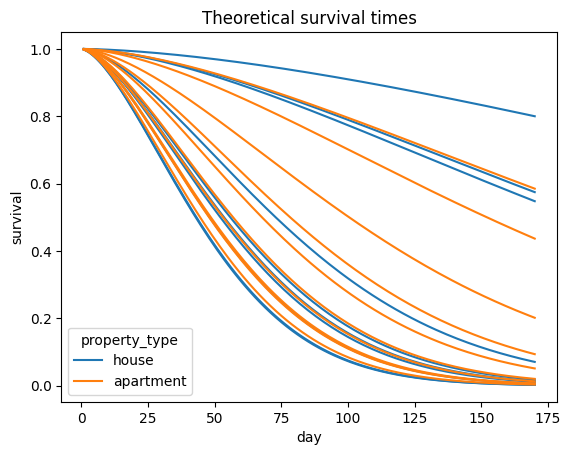

In [29]:
sns.lineplot(x='day', y='survival', data=df_surv_long, units='id', hue='property_type', estimator=None)
plt.title(f"Theoretical survival times")
plt.show()


### Extended

In [30]:
colnames_x_numeric_tidy

['property_type',
 'first_price',
 'diff_first_prediction',
 'page_on_marketplace',
 'latitude',
 'longitude',
 'woe_marketplace',
 'woe_seller',
 'woe_id_sepomex',
 'sine_tmonth',
 'cosine_tmonth']

In [31]:
def get_extended_survival_df(X, y, model, ids, df, cols, tau=365):
    # predict 
    df_predictions = extrapolate_constant_risk(
        survival=model.predict(X),
        final_time=tau,
        intervals=1
    )

    # get rmse, mape and cindex by listing & property type
    df_surv = (
        pd.DataFrame()
        .assign(
            id=ids,
            observed_time=y['Survival_in_days'],
            event=y['Status'],
        )
        .merge(
            df[['id'] + cols],
            how='inner',
            on='id'
        )
    )
    df_surv = pd.concat([df_surv, df_predictions], axis=1)

    # rename columns that are numbers to "day_*"
    df_surv = df_surv.rename(columns={col: f'day_{int(col)}' for col in df_surv.columns if type(col) == float})

    return df_surv

# from colnames_x_numeric change 'listing_type=for-sale' for 'listing_type' and 'property_type=house' for 'property_type'
colnames_x_numeric_tidy = [col.replace('property_type=house', 'property_type') for col in colnames_x_numeric]
colnames_x_numeric_tidy

# get predictions
df_surv = get_extended_survival_df(X_test, y_test, xgbse_weibull, ids=test_ids, df=df_model, cols=colnames_x_numeric_tidy, tau=365)

# cols with 'day_*'
cols_day = [col for col in df_surv.columns if 'day_' in col]

In [32]:
# to long
df_surv_long = (
    df_surv
    .groupby(['property_type'])
    .sample(100, random_state=33)
    .reset_index(drop=True)
    .melt(id_vars=['id', 'property_type'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'day'])
)
df_surv_long

,id,property_type,day,survival
58,026577bb46bde393d0f1d284e9a578e0,apartment,1,0.999953
258,026577bb46bde393d0f1d284e9a578e0,apartment,2,0.999857
458,026577bb46bde393d0f1d284e9a578e0,apartment,3,0.999724
658,026577bb46bde393d0f1d284e9a578e0,apartment,4,0.999561
858,026577bb46bde393d0f1d284e9a578e0,apartment,5,0.999369
...,...,...,...,...
72106,ff3a8eb3d221013dfa580b1fa185dbb0,house,361,0.185572
72306,ff3a8eb3d221013dfa580b1fa185dbb0,house,362,0.184523
72506,ff3a8eb3d221013dfa580b1fa185dbb0,house,363,0.183481
72706,ff3a8eb3d221013dfa580b1fa185dbb0,house,364,0.182444


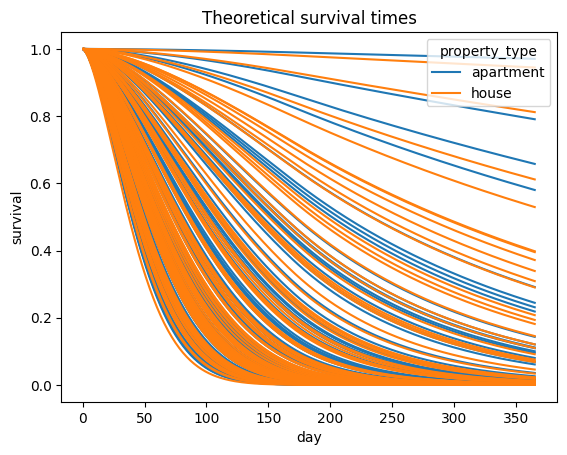

In [33]:
sns.lineplot(x='day', y='survival', data=df_surv_long, units='id', hue='property_type', estimator=None)
plt.title(f"Theoretical survival times")
plt.show()


### Root Finding

In [34]:
def quantile_function(day, q=0.8, group=None):
    # Calculate the empirical quantile based on 'day' and 'survival'
    quantile_value = group[group['day'] <= day]['survival'].min()
    return quantile_value - q

# Create a function to apply to each group (each 'id')
def get_quantile(group, target_quantile=0.8):
    try:
        result = brentq(quantile_function, a=1, b=365*2, args=(target_quantile, group))
    except:
        result = np.nan
    return pd.Series({'quantile_80': result})

# Apply the function to each 'id' group and store the results in a new DataFrame
result_df = df_surv_long.groupby(['id']).apply(get_quantile, target_quantile=1-0.9).reset_index().sort_values(by='quantile_80', ascending=False)
result_df

,id,quantile_80
45,239d087b565e3bf3555a59ee5000a749,360.0
66,3ea41b73699682a2175ea23714f1d151,354.0
111,7e811ce499c5783963749462dbd9780e,339.0
14,0bab5e1ec17fa939cb509272f7912d95,333.0
92,6167a0f49541c0ae98c8546f128b2994,328.0
...,...,...
170,d15f799ab8da1e51cad365f213515418,NaN
176,d9afe71f82885d11444cfdd85edfec6a,NaN
189,ef531f09b1f47c25f1f47984e6a654b6,NaN
198,fdf4266ccf10a8e8555734a0f60c0de0,NaN


# Quantile Prediction

## Predict

In [35]:
# get predictions
df_quantile90_surv = (
    get_extended_survival_df(
        X_test, y_test, 
        xgbse_weibull, 
        ids=test_ids, 
        df=df_model, 
        cols=colnames_x_numeric_tidy, 
        tau=365*2
    )
    # .groupby(['property_type', 'event'])
    # .sample(100, random_state=33)
    .reset_index(drop=True)
    .melt(id_vars=['id', 'property_type'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'day'])
    .groupby(['id'])
    .apply(get_quantile, target_quantile=1-0.8)
    .reset_index()
    .merge(df_model, how='inner', on='id')
)


## look calibration

### Quantile

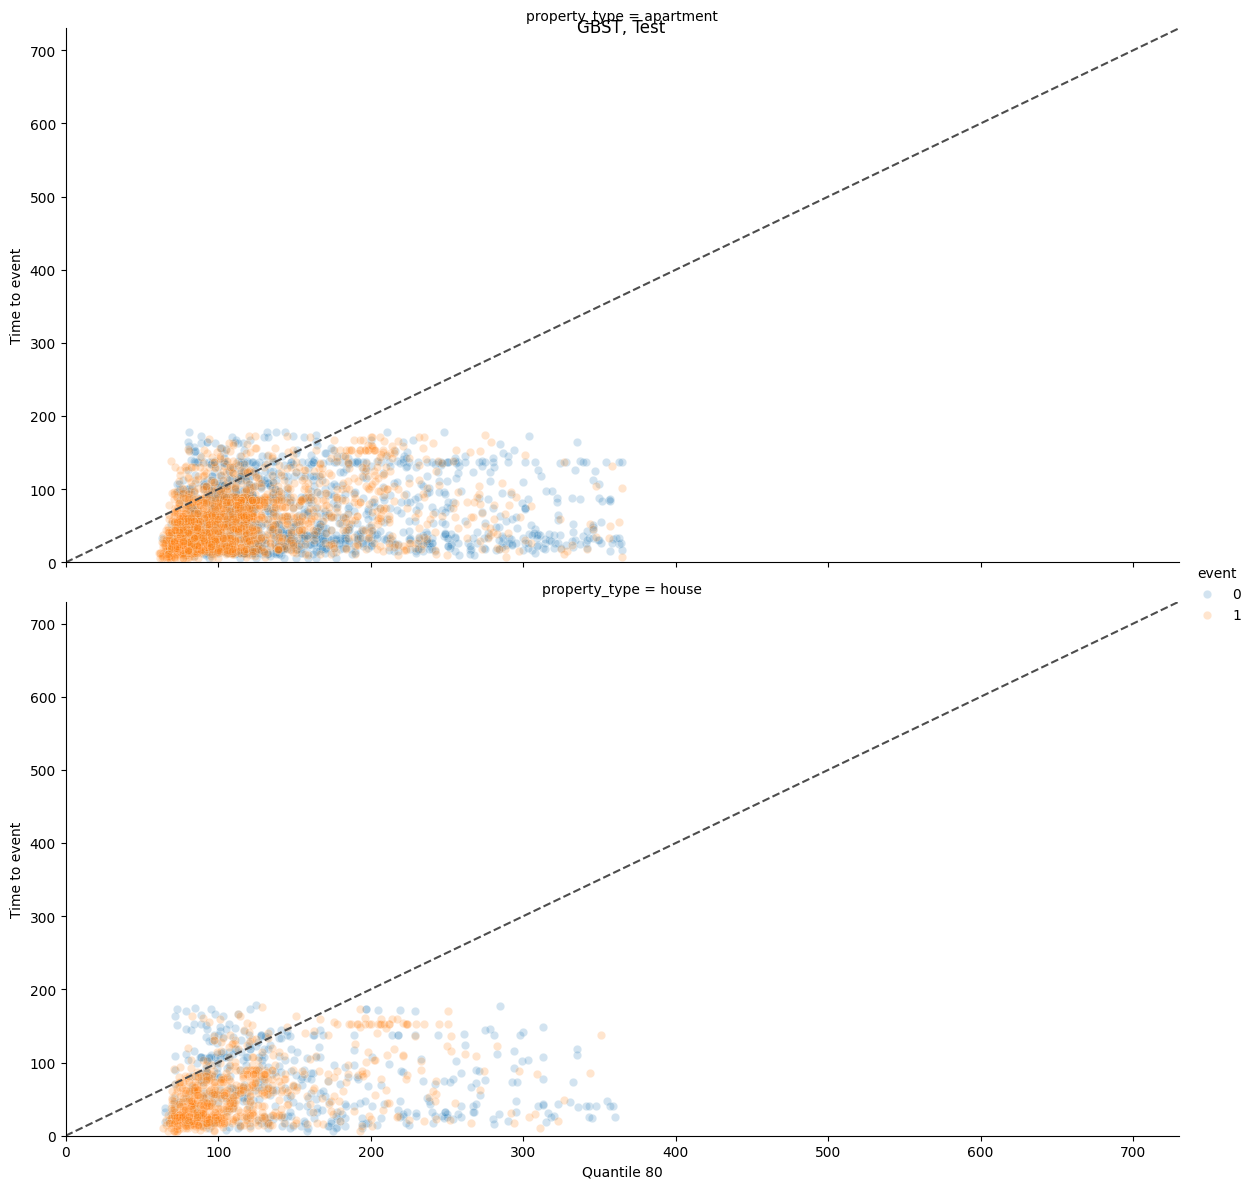

In [36]:
# plot quantile_80 vs time2event, facet grid listing_type and property_type and hue by event
g = sns.FacetGrid(df_quantile90_surv, row='property_type', hue='event')

# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)

# plot a scatter plot
g.map(sns.scatterplot, 'quantile_80', 'time2event', alpha=0.2)

# extend limits of x axis
g.set(xlim=(0, 365*2), ylim=(0, 365*2))

# Add the identity line to each facet
for ax in g.axes.flat:
    ax.plot([0, 365*2], [0, 365*2], ls="--", c=".3")

g.set_axis_labels('Quantile 80', 'Time to event')
g.fig.suptitle('GBST, Test')

# add legend
g.add_legend()

plt.show()


In [37]:
# get calibration by listing_type and property_type
(
    df_quantile90_surv
    .assign(
        is_higher=lambda x: np.where(x['time2event'] > x['quantile_80'], 1, 0),
    )
    .groupby(['property_type', 'event'])
    .agg({'is_higher': 'mean'})
)

is_higher
property_type event           
apartment     0       0.099713
              1       0.069869
house         0       0.145669
              1       0.063063

### Kaplan Mier vs Model

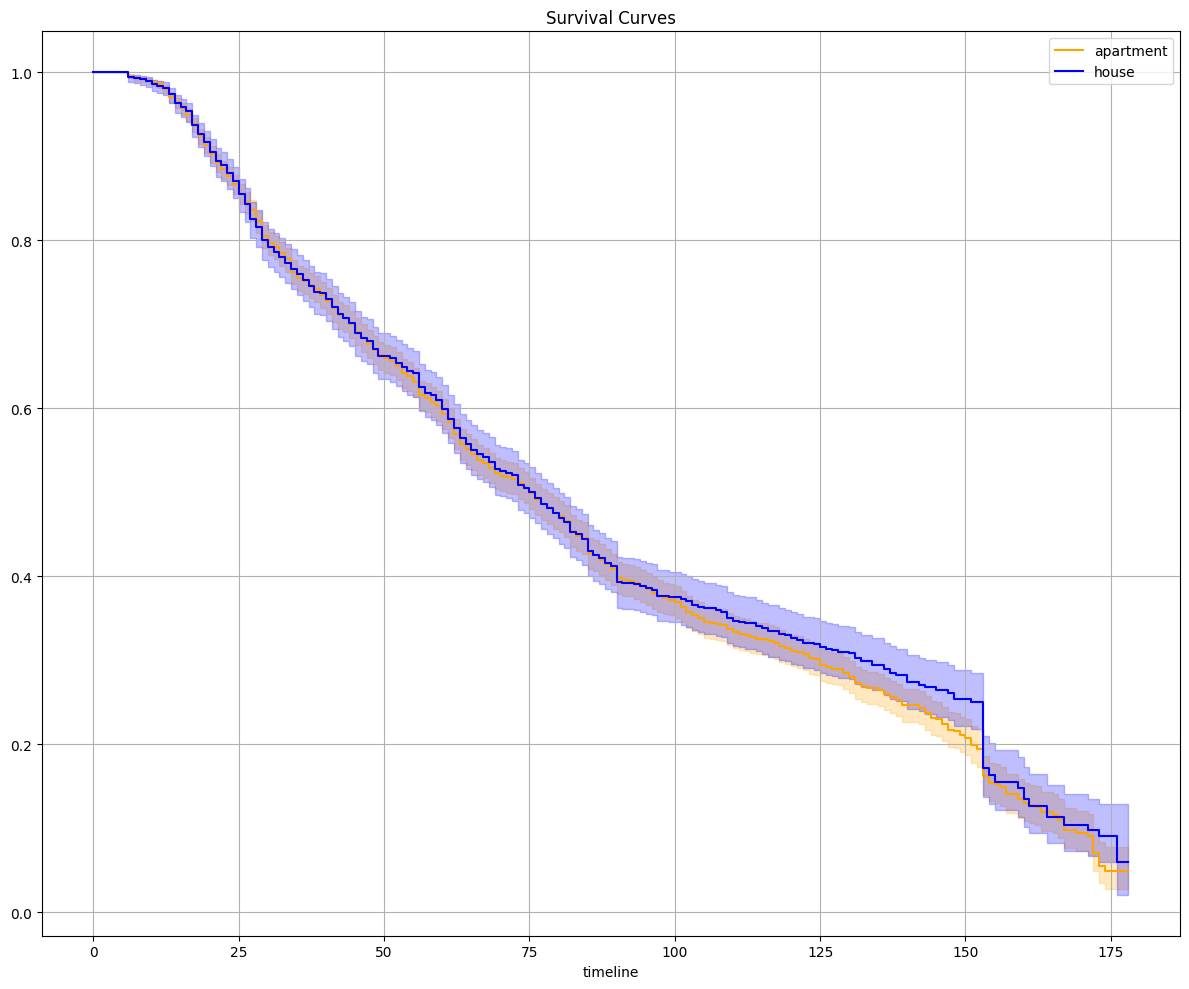

In [38]:
# create a KM plot for each listing_type and property_type if X_test
# first get dataframe with times
df_test_times = pd.DataFrame({
    'time2event': y_test['Survival_in_days'],
    'event': y_test['Status'],
    'property_type': X_test[:, 0],
    'id': test_ids
}).assign(
    property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
)


# create a KM plot for each listing_type and property_type for df_test_times
def plot_km(df):
    df = df.copy()
    ax = plt.subplot(111)

    dict_km = {}

    for property_type in ['apartment', 'house']:
        # get key
        df_rent = df[
            (df['property_type'] == property_type)
            ].copy()
        
        # estimate
        kmf = lifelines.KaplanMeierFitter()
        ax = kmf.fit(
            df_rent['time2event'],
            df_rent['event'],
            label=property_type
        ).plot_survival_function(
            ci_show=True,
            figsize=(12, 10),
            color=('b' if property_type == 'house' else 'orange'),
            title='Survival Curves'
        )

        # add km to dict
        dict_km[property_type] = kmf
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    return

plot_km(df_test_times)

In [39]:
# get df test with modified values
df_test_x_numeric = pd.DataFrame(X_test, columns=colnames_x_numeric)
df_test_x_numeric

# apply mean by listing_type and property_type
df_test_x_numeric_artificial = (
    df_test_x_numeric.copy()
    .groupby(["property_type=house"])
    .apply('mean')
    .reset_index()
    )

# predict
df_test_extended_surv = (
    extrapolate_constant_risk(
        survival=xgbse_weibull.predict(df_test_x_numeric_artificial.values),
        final_time=365*2,
        intervals=1
    )
    .assign(
        property_type=df_test_x_numeric_artificial['property_type=house'].\
            apply(lambda x: 'house' if x == 1 else 'apartment'),
    )
    .melt(id_vars=['property_type'], value_vars=range(1, 365))
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .sort_values(by=['property_type', 'day'])
)
df_test_extended_surv

,property_type,day,survival
0,apartment,1.0,0.999608
2,apartment,2.0,0.998819
4,apartment,3.0,0.997749
6,apartment,4.0,0.996443
8,apartment,5.0,0.994929
...,...,...,...
719,house,360.0,0.104319
721,house,361.0,0.103527
723,house,362.0,0.102741
725,house,363.0,0.101960


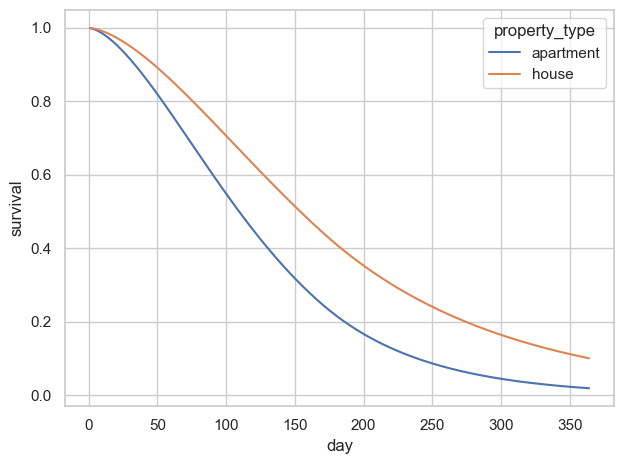

In [40]:
# plot a lineplot, colored by listing_type and linetype by property_type
sns.set_theme(style="whitegrid")
sns.lineplot(x='day', y='survival', data=df_test_extended_surv, hue='property_type', estimator=None)
plt.tight_layout()

In [41]:
# fit a kaplan meier for each listing_type and property_type and then plot
km_fits = {}
for property_type in ['apartment', 'house']:
    # get key
    df_rent = df_test_times[
        (df_test_times['property_type'] == property_type)
        ].copy()
    
    # estimate
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(
        df_rent['time2event'],
        df_rent['event'],
        label=property_type
    )
    km_fits[property_type] = kmf

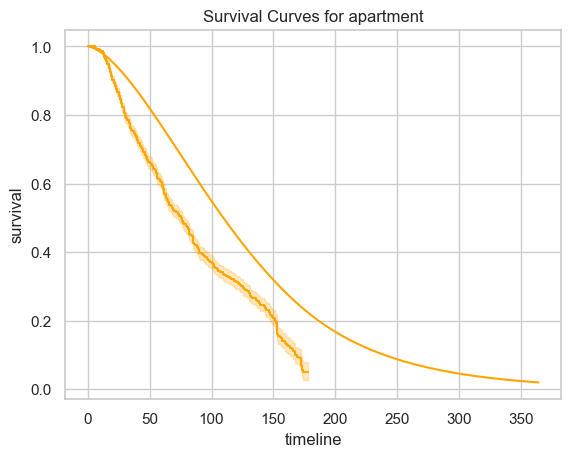

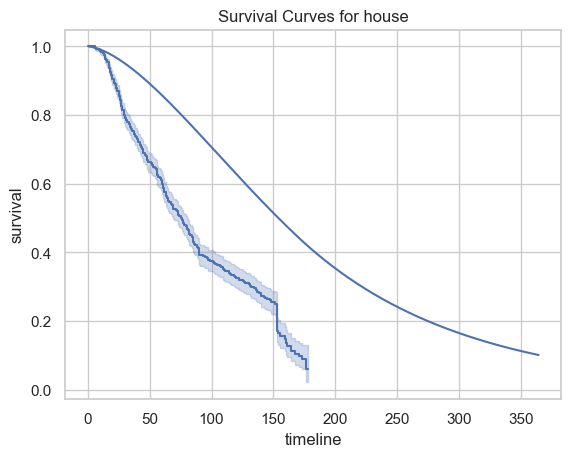

In [42]:
# plot a lineplot for each listing_type and property_type using the km and df_test_extended_surv
for property_type in ['apartment', 'house']:
    # get key

    # plot km
    km_fits[property_type].plot_survival_function(
        ci_show=True,
        color=('b' if property_type == 'house' else 'orange'),
        title=f'Survival Curves for {property_type}'
    )
    # plot lineplot
    sns.lineplot(
        x='day', y='survival', 
        data=df_test_extended_surv.query(f"property_type == '{property_type}'"), 
        estimator=None,
        color=('b' if property_type == 'house' else 'orange'),
    )
    # dont show legend
    plt.legend().remove()
    plt.show()


# Business Sense

For a given listing, i should watch:

- higher price implies more time
- higher woe implies less time

## Multiplier

In [106]:
# Function to create synthetic observations
def create_synthetic_observations(df_examples, multiplier):
    df_synthetic = pd.DataFrame()
    
    for _, row in df_examples.iterrows():
        # Get the original row data
        price, diff_first_prediction = row['first_price'], row['diff_first_prediction']
        
        # Create new rows for each multiplier
        for mult in multiplier:
            new_price = price * mult
            new_diff_first_prediction = (diff_first_prediction + 1 - 1/mult) * mult
            
            # Create a new row with modified values
            new_row = row.copy()
            new_row['first_price'] = new_price
            new_row['diff_first_prediction'] = new_diff_first_prediction
            new_row['label_price'] = mult
            
            # Concatenate the new row to the synthetic dataframe
            df_synthetic = pd.concat([df_synthetic, new_row.to_frame().transpose()], ignore_index=True)
    
    return df_synthetic


# Example usage:
df_surv = get_extended_survival_df(X_test, y_test, xgbse_weibull, ids=test_ids, df=df_model, cols=colnames_x_numeric_tidy, tau=365)
df_examples = df_surv.sample(4, random_state=99).copy()

multiplier = np.array([0.5, 1, 1.5, 2])
df_synthetic = create_synthetic_observations(df_examples, multiplier)

In [107]:
df_examples

,id,observed_time,event,property_type,first_price,diff_first_prediction,page_on_marketplace,latitude,longitude,woe_marketplace,...,day_356,day_357,day_358,day_359,day_360,day_361,day_362,day_363,day_364,day_365
2900,d7e01de03d4dc9b6ec5b3659f899b146,21.0,True,house,2400000.0,-0.221649,1.0,19.389215,-99.098356,0.533409,...,7.412721e-08,7.010554e-08,6.630206e-08,6.270493e-08,5.930297e-08,5.608557e-08,5.304272e-08,5.016496e-08,4.744333e-08,4.486936e-08
3735,c434e27ef429725c978f79078f3b1cf4,40.0,True,house,3990000.0,0.956470,1.0,19.464145,-99.163185,0.223425,...,9.428215e-07,8.993845e-07,8.579488e-07,8.184221e-07,7.807164e-07,7.447478e-07,7.104364e-07,6.777057e-07,6.464830e-07,6.166987e-07
37,f179d252a05a6cd909cc63553f45d8cc,56.0,True,apartment,3870000.0,0.022744,3.0,19.395800,-99.186200,0.533409,...,1.668403e-04,1.619717e-04,1.572452e-04,1.526565e-04,1.482018e-04,1.438771e-04,1.396786e-04,1.356026e-04,1.316455e-04,1.278040e-04
26,d4e56e11b34c848d0fe3d1b0762ebc2c,74.0,False,apartment,2050000.0,-0.005573,1.0,19.299880,-99.107181,-1.017859,...,8.130577e-02,8.061131e-02,7.992278e-02,7.924013e-02,7.856331e-02,7.789227e-02,7.722696e-02,7.656734e-02,7.591335e-02,7.526495e-02


In [108]:
df_synthetic

,id,observed_time,event,property_type,first_price,diff_first_prediction,page_on_marketplace,latitude,longitude,woe_marketplace,...,day_357,day_358,day_359,day_360,day_361,day_362,day_363,day_364,day_365,label_price
0,d7e01de03d4dc9b6ec5b3659f899b146,21.0,True,house,1200000.0,-0.610825,1.0,19.389215,-99.098356,0.533409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,d7e01de03d4dc9b6ec5b3659f899b146,21.0,True,house,2400000.0,-0.221649,1.0,19.389215,-99.098356,0.533409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,d7e01de03d4dc9b6ec5b3659f899b146,21.0,True,house,3600000.0,0.167526,1.0,19.389215,-99.098356,0.533409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
3,d7e01de03d4dc9b6ec5b3659f899b146,21.0,True,house,4800000.0,0.556702,1.0,19.389215,-99.098356,0.533409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,c434e27ef429725c978f79078f3b1cf4,40.0,True,house,1995000.0,-0.021765,1.0,19.464145,-99.163185,0.223425,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.5
5,c434e27ef429725c978f79078f3b1cf4,40.0,True,house,3990000.0,0.95647,1.0,19.464145,-99.163185,0.223425,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1.0
6,c434e27ef429725c978f79078f3b1cf4,40.0,True,house,5985000.0,1.934704,1.0,19.464145,-99.163185,0.223425,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1.5
7,c434e27ef429725c978f79078f3b1cf4,40.0,True,house,7980000.0,2.912939,1.0,19.464145,-99.163185,0.223425,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,2.0
8,f179d252a05a6cd909cc63553f45d8cc,56.0,True,apartment,1935000.0,-0.488628,3.0,19.3958,-99.1862,0.533409,...,0.000162,0.000157,0.000153,0.000148,0.000144,0.00014,0.000136,0.000132,0.000128,0.5
9,f179d252a05a6cd909cc63553f45d8cc,56.0,True,apartment,3870000.0,0.022744,3.0,19.3958,-99.1862,0.533409,...,0.000162,0.000157,0.000153,0.000148,0.000144,0.00014,0.000136,0.000132,0.000128,1.0


In [109]:
# transform df_synthetic to numeric and get predictions
df_synthetic['property_type=house'] = np.where(df_synthetic['property_type'] == 'house', 1, 0)
df_synthetic_numeric = pd.DataFrame(df_synthetic, columns=colnames_x_numeric)

# boxcox
df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 1, boxcox_vars_property] =\
      pt_house.transform(df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 1, boxcox_vars_property])
df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 0, boxcox_vars_property] =\
        pt_apartment.transform(df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 0, boxcox_vars_property])
df_synthetic_numeric[boxcox_vars_all] = pt_all.transform(df_synthetic_numeric[boxcox_vars_all])

# scale
# df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 1, standard_vars] =\
#       st_house.transform(df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 1, standard_vars])
# df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 0, standard_vars] =\
#         st_apartment.transform(df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 0, standard_vars])

# to numeric
df_synthetic_numeric


,property_type=house,first_price,diff_first_prediction,page_on_marketplace,latitude,longitude,woe_marketplace,woe_seller,woe_id_sepomex,sine_tmonth,cosine_tmonth
0,1,-2.648484,-4.242421,-1.195940,19.389215,-99.098356,0.533409,1.008321,0.200317,0.0,-1.0
1,1,-1.840275,-1.482904,-1.195940,19.389215,-99.098356,0.533409,1.008321,0.200317,0.0,-1.0
2,1,-1.346716,0.614957,-1.195940,19.389215,-99.098356,0.533409,1.008321,0.200317,0.0,-1.0
3,1,-0.986882,2.190766,-1.195940,19.389215,-99.098356,0.533409,1.008321,0.200317,0.0,-1.0
4,1,-2.060097,-0.323303,-1.195940,19.464145,-99.163185,0.223425,-0.025435,0.200317,0.5,-0.866025
5,1,-1.218994,3.488270,-1.195940,19.464145,-99.163185,0.223425,-0.025435,0.200317,0.5,-0.866025
6,1,-0.705346,5.893295,-1.195940,19.464145,-99.163185,0.223425,-0.025435,0.200317,0.5,-0.866025
7,1,-0.330867,7.683358,-1.195940,19.464145,-99.163185,0.223425,-0.025435,0.200317,0.5,-0.866025
8,0,-1.467271,-3.305712,-0.230376,19.3958,-99.1862,0.533409,-0.025435,0.200317,0.866025,-0.5
9,0,-0.309933,-0.089468,-0.230376,19.3958,-99.1862,0.533409,-0.025435,0.200317,0.866025,-0.5


In [113]:
def get_extended_survival_df2(X, model, multi, ids, df, cols, tau=365):
    # predict 
    df_predictions = extrapolate_constant_risk(
        survival=model.predict(X),
        final_time=tau,
        intervals=1
    )

    # get rmse, mape and cindex by listing & property type
    df_surv = (
        pd.DataFrame()
        .assign(
            id=ids,
            label_price=multi,
        )
        .merge(
            df[['id', 'label_price'] + cols],
            how='inner',
            on=['id', 'label_price']
        )
    )
    df_surv = pd.concat([df_surv, df_predictions], axis=1)

    # rename columns that are numbers to "day_*"
    df_surv = df_surv.rename(columns={col: f'day_{int(col)}' for col in df_surv.columns if type(col) == float})

    return df_surv

# predict
df_surv = get_extended_survival_df2(
    X=df_synthetic_numeric.values, 
    model=xgbse_weibull, 
    multi=df_synthetic.label_price.values, 
    ids=df_synthetic.id.values, 
    df=df_synthetic,
    cols=colnames_x_numeric_tidy,
    tau=365
    )
cols_day = [col for col in df_surv.columns if 'day_' in col]


In [114]:
# to long
df_surv_long = (
    df_surv
    .reset_index(drop=True)
    .melt(id_vars=['id', 'label_price'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'label_price', 'day'])
)
df_surv_long

,id,label_price,day,survival
4,c434e27ef429725c978f79078f3b1cf4,0.5,1,0.998119
20,c434e27ef429725c978f79078f3b1cf4,0.5,2,0.994418
36,c434e27ef429725c978f79078f3b1cf4,0.5,3,0.989467
52,c434e27ef429725c978f79078f3b1cf4,0.5,4,0.983494
68,c434e27ef429725c978f79078f3b1cf4,0.5,5,0.976640
...,...,...,...,...
5771,f179d252a05a6cd909cc63553f45d8cc,2.0,361,0.000420
5787,f179d252a05a6cd909cc63553f45d8cc,2.0,362,0.000409
5803,f179d252a05a6cd909cc63553f45d8cc,2.0,363,0.000398
5819,f179d252a05a6cd909cc63553f45d8cc,2.0,364,0.000388


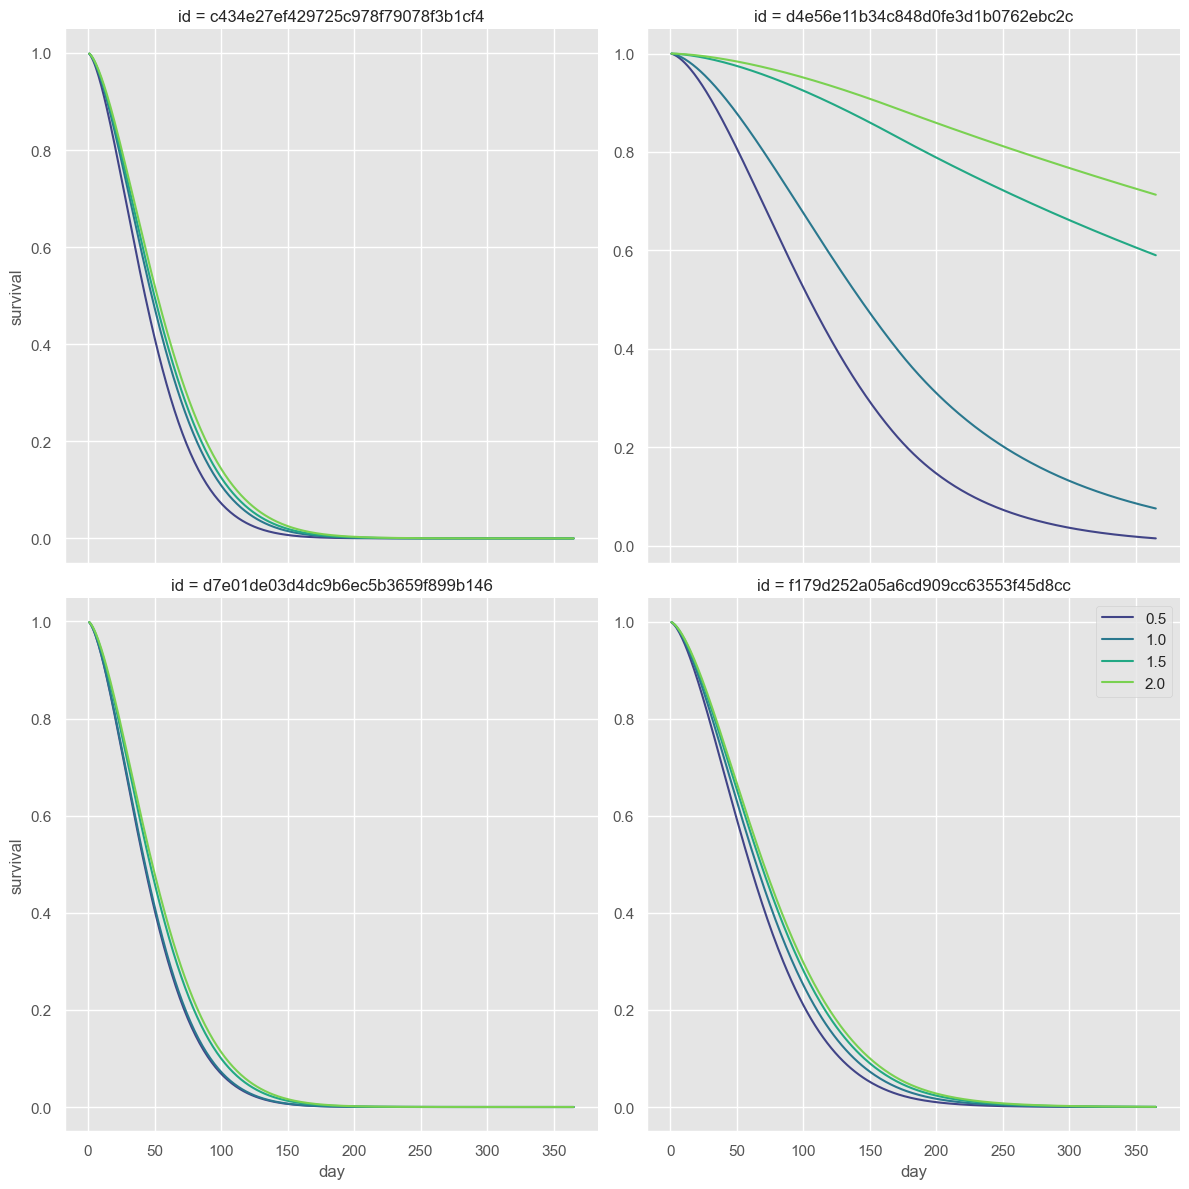

In [115]:
# plot survival curves, facet wrap by id
# set ggplot style
plt.style.use('ggplot')
g = sns.FacetGrid(df_surv_long, col='id', col_wrap=2, hue='label_price', sharey=False, palette='viridis')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.lineplot, 'day', 'survival')
plt.tight_layout()
plt.legend()
plt.show()


# sns.lineplot(x='day', y='survival', data=df_surv_long, units='id', hue='label_price', estimator=None)
# plt.title(f"Theoretical survival times")
# plt.show()

In [50]:
df_surv.id.unique()

array(['d7e01de03d4dc9b6ec5b3659f899b146',
       'c434e27ef429725c978f79078f3b1cf4',
       'f179d252a05a6cd909cc63553f45d8cc',
       'd4e56e11b34c848d0fe3d1b0762ebc2c'], dtype=object)

In [51]:
df_model.query("id == 'd4e56e11b34c848d0fe3d1b0762ebc2c'").to_dict()

{'id': {39459: 'd4e56e11b34c848d0fe3d1b0762ebc2c'},
 'marketplace': {39459: 'easybroker'},
 'first_observed_date': {39459: Timestamp('2023-08-03 11:19:45')},
 'last_observed_date': {39459: Timestamp('2023-10-16 16:11:39')},
 'count_repeated': {39459: 1},
 'time2event': {39459: 74.0},
 'event': {39459: 0},
 'id_sepomex': {39459: '11732'},
 'listing_type': {39459: 'for-sale'},
 'property_type': {39459: 'apartment'},
 'is_development': {39459: 0},
 'is_exterior': {39459: 0.0},
 'is_penthouse': {39459: 0.0},
 'first_price': {39459: 2050000.0},
 'last_price': {39459: 1800000.0},
 'surface_total': {39459: 62.0},
 'num_bathrooms': {39459: 1.0},
 'num_parking_lots': {39459: 1.0},
 'num_bedrooms': {39459: 2.0},
 'cost_of_maintenance': {39459: 0.0},
 'is_new_property_prob': {39459: 0.4059977181255817},
 'prediction_price': {39459: 2061488.082953994},
 'prediction_price_per_square_meter': {39459: 33249.80778958055},
 'longitude': {39459: -99.1071808},
 'latitude': {39459: 19.2998796},
 'has_balco

## Baised Multiplier

Look curves if 
- same month
- woe seller
- woe market

In [128]:
# get woe_marketplace, woe_seller and sine_tmonth & cosine_tmonth of the id d4e56e11b34c848d0fe3d1b0762ebc2c
df_examples2 = df_examples.copy()
cols2replace = ['woe_marketplace', 'woe_seller', 'sine_tmonth', 'cosine_tmonth']
data_aux = df_examples2.query("id == 'd4e56e11b34c848d0fe3d1b0762ebc2c'")[cols2replace]

# replace all values of woe_marketplace, woe_seller and sine_tmonth & cosine_tmonth with the values of data_aux for all rows of df_examples, use a map
df_examples2[cols2replace] = df_examples2[cols2replace].apply(lambda x: data_aux.iloc[0], axis=1)

In [129]:
data_aux

,woe_marketplace,woe_seller,sine_tmonth,cosine_tmonth
26,-1.017859,-1.044053,-0.866025,-0.5


In [130]:
# multiplier
multiplier = np.array([0.5, 1, 1.5, 2])
df_synthetic = create_synthetic_observations(df_examples2, multiplier)

# transform
# transform df_synthetic to numeric and get predictions
df_synthetic['property_type=house'] = np.where(df_synthetic['property_type'] == 'house', 1, 0)
df_synthetic_numeric = pd.DataFrame(df_synthetic, columns=colnames_x_numeric)

# boxcox
df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 1, boxcox_vars_property] =\
      pt_house.transform(df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 1, boxcox_vars_property])
df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 0, boxcox_vars_property] =\
        pt_apartment.transform(df_synthetic_numeric.loc[df_synthetic_numeric['property_type=house'] == 0, boxcox_vars_property])
df_synthetic_numeric[boxcox_vars_all] = pt_all.transform(df_synthetic_numeric[boxcox_vars_all])

# to numeric

# predict
df_surv = get_extended_survival_df2(
    X=df_synthetic_numeric.values, 
    model=xgbse_weibull, 
    multi=df_synthetic.label_price.values, 
    ids=df_synthetic.id.values, 
    df=df_synthetic,
    cols=colnames_x_numeric_tidy,
    tau=365*2
    )

cols_day = [col for col in df_surv.columns if 'day_' in col]

# to long
df_surv_long = (
    df_surv
    .reset_index(drop=True)
    .melt(id_vars=['id', 'label_price'], value_vars=cols_day)
    .rename(columns={'variable': 'day', 'value': 'survival'})
    .assign(day=lambda x: x['day'].str.replace('day_', '').astype(int))
    .sort_values(by=['id', 'label_price', 'day'])
)

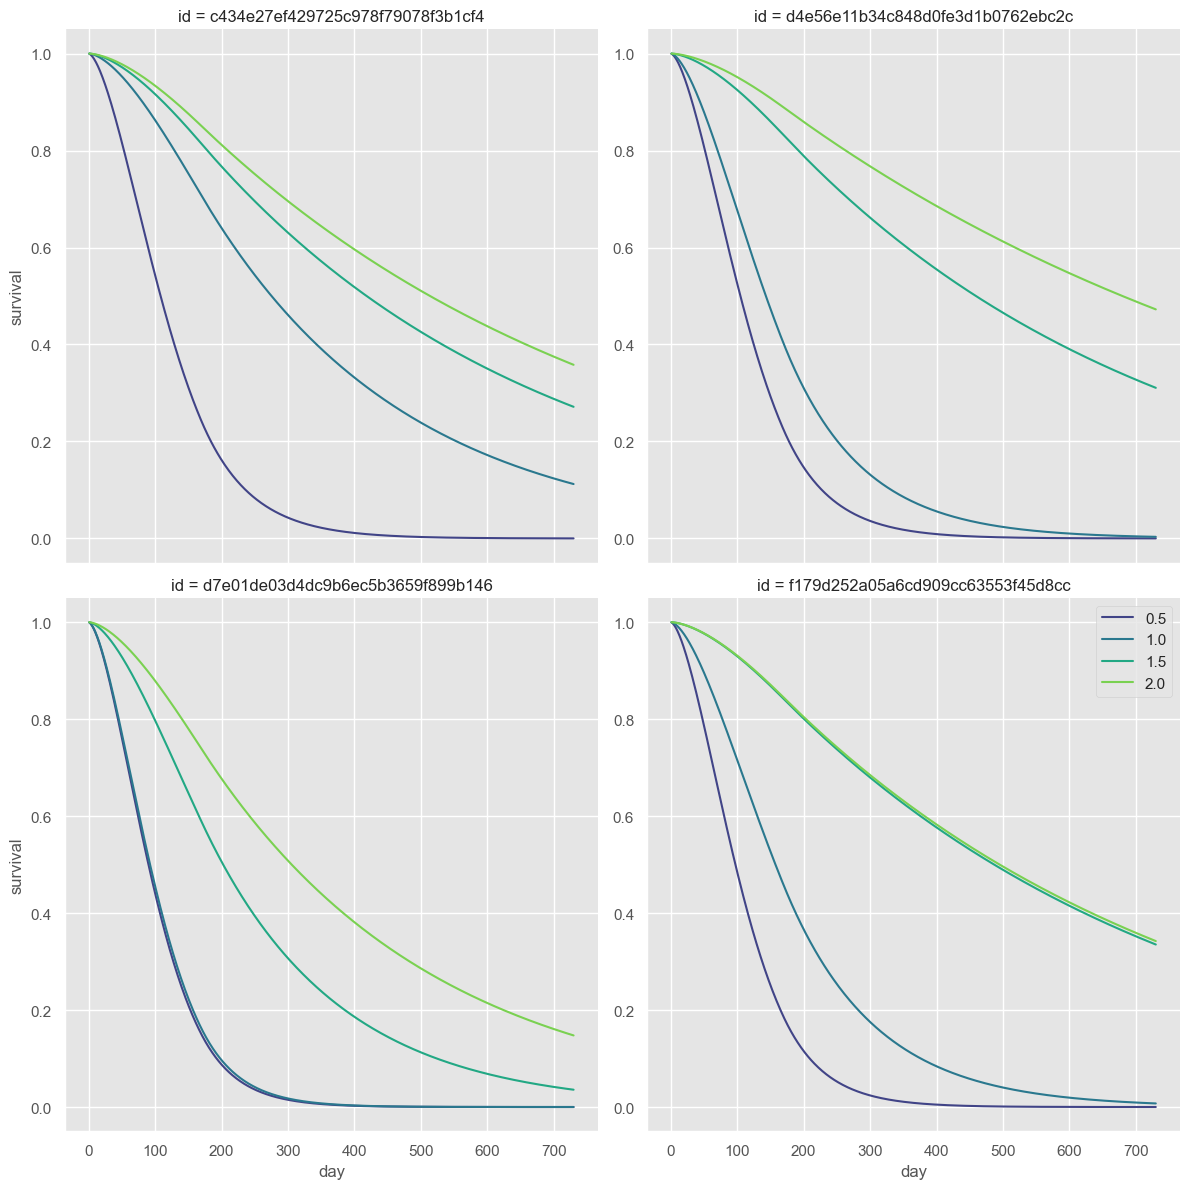

In [131]:
# plot survival curves, facet wrap by id
# set ggplot style
plt.style.use('ggplot')
g = sns.FacetGrid(df_surv_long, col='id', col_wrap=2, hue='label_price', sharey=False, palette='viridis')
# fig size 12, 12
g.fig.set_figwidth(12)
g.fig.set_figheight(12)
g.map(sns.lineplot, 'day', 'survival')
plt.tight_layout()
plt.legend()
plt.show()
